# Multi-objective Risk-based Resource Allocation

In [2]:
import geopandas as gp
import networkx as nx
import pandas as pd
import numpy as np
import unidecode
import string
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats
import warnings
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from matplotlib.patches import Patch
import matplotlib.colors 

from scipy.stats import chisquare, anderson, kstest

import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from scipy.spatial import distance

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Load the Urban Sector Shapes

In [4]:
sectorUrbano = gp.read_file('./Data/MGN2018_URB_SECTOR')
sectorUrbano = sectorUrbano[(sectorUrbano['DPTO_CCDGO'] == '11') & (sectorUrbano['SETU_CCDGO'] != '0001')]
tost = sectorUrbano.copy()
tost = tost.to_crs({'init': 'epsg:3857'})
tost['area'] = tost['geometry'].area/ 10**6
dictAreas = tost.set_index('SETU_CCDGO')['area'].to_dict()
sectorUrbano['area'] = sectorUrbano['SETU_CCDGO'].apply(lambda x: dictAreas[x])
sectorUrbano['centroid'] = sectorUrbano.centroid

sectorUrbano

DPTO_CCDGO MPIO_CCDGO CPOB_CCDGO          SETU_CCNCT  SHAPE_Leng  \
1538         11      11001   11001000  110011000000001101    0.017602   
1539         11      11001   11001000  110011000000001102    0.024178   
1540         11      11001   11001000  110011000000001103    0.051139   
1541         11      11001   11001000  110011000000001104    0.032833   
1542         11      11001   11001000  110011000000001105    0.072244   
...         ...        ...        ...                 ...         ...   
2164         11      11001   11001000  110011000000009218    0.048764   
2165         11      11001   11001000  110011000000009219    0.058952   
2166         11      11001   11001000  110011000000009220    0.036532   
2167         11      11001   11001000  110011000000009221    0.033188   
2168         11      11001   11001000  110011000000009222    0.083100   

      SHAPE_Area SETU_CCDGO  \
1538    0.000014       1101   
1539    0.000021       1102   
1540    0.000072       1103   
1541    0.000032       1104   
1542    0.000071       1105   
...          ...        ...   
2164    0.000086       9218   
2165    0.000052       9219   
2166    0.000043       9220   
2167    0.000028       9221   
2168    0.000214       9222   

                                               geometry      area  \
1538  POLYGON ((-74.08034 4.58187, -74.08064 4.58165...  0.172533   
1539  POLYGON ((-74.07819 4.58107, -74.07789 4.58081...  0.266636   
1540  POLYGON ((-74.07046 4.57786, -74.07037 4.57765...  0.896132   
1541  POLYGON ((-74.06825 4.56809, -74.06821 4.56800...  0.400737   
1542  POLYGON ((-74.07426 4.56748, -74.07413 4.56735...  0.885145   
...                                                 ...       ...   
2164  POLYGON ((-74.12461 4.75408, -74.12354 4.75406...  1.071749   
2165  POLYGON ((-74.11956 4.74809, -74.11954 4.74809...  0.641471   
2166  POLYGON ((-74.09222 4.73695, -74.09221 4.73695...  0.528884   
2167  POLYGON ((-74.12395 4.74975, -74.12378 4.74919...  0.349619   
2168  POLYGON ((-74.11508 4.76192, -74.11392 4.76096...  2.656149   

                       centroid  
1538  POINT (-74.08160 4.58323)  
1539  POINT (-74.08002 4.57926)  
1540  POINT (-74.07353 4.57410)  
1541  POINT (-74.06817 4.56410)  
1542  POINT (-74.07707 4.56209)  
...                         ...  
2164  POINT (-74.11539 4.75006)  
2165  POINT (-74.12417 4.74352)  
2166  POINT (-74.09257 4.73487)  
2167  POINT (-74.12691 4.74612)  
2168  POINT (-74.10850 4.75636)  

[631 rows x 10 columns]

## Read the vulnerability variables

In [5]:
variables = pd.read_excel("./Data/variables_vulnerability.xlsx")

variables = variables[['SETU_CCDGO'] + variables.keys()[-15:].tolist()]
factors = variables.keys()[-15:].tolist()
variablesdict = variables.set_index('SETU_CCDGO', drop=True).to_dict()

sectorUrbanoWithVariables = sectorUrbano.copy()

for fc in factors:
    sectorUrbanoWithVariables[fc] = sectorUrbano['SETU_CCDGO'].apply(lambda x: variablesdict[fc][int(x)])

sectorUrbanoWithVariables = sectorUrbanoWithVariables.rename(columns={"Geographic Spread": "Geographic Impact"})
sectorUrbanoWithVariables

DPTO_CCDGO MPIO_CCDGO CPOB_CCDGO          SETU_CCNCT  SHAPE_Leng  \
1538         11      11001   11001000  110011000000001101    0.017602   
1539         11      11001   11001000  110011000000001102    0.024178   
1540         11      11001   11001000  110011000000001103    0.051139   
1541         11      11001   11001000  110011000000001104    0.032833   
1542         11      11001   11001000  110011000000001105    0.072244   
...         ...        ...        ...                 ...         ...   
2164         11      11001   11001000  110011000000009218    0.048764   
2165         11      11001   11001000  110011000000009219    0.058952   
2166         11      11001   11001000  110011000000009220    0.036532   
2167         11      11001   11001000  110011000000009221    0.033188   
2168         11      11001   11001000  110011000000009222    0.083100   

      SHAPE_Area SETU_CCDGO  \
1538    0.000014       1101   
1539    0.000021       1102   
1540    0.000072       1103   
1541    0.000032       1104   
1542    0.000071       1105   
...          ...        ...   
2164    0.000086       9218   
2165    0.000052       9219   
2166    0.000043       9220   
2167    0.000028       9221   
2168    0.000214       9222   

                                               geometry      area  \
1538  POLYGON ((-74.08034 4.58187, -74.08064 4.58165...  0.172533   
1539  POLYGON ((-74.07819 4.58107, -74.07789 4.58081...  0.266636   
1540  POLYGON ((-74.07046 4.57786, -74.07037 4.57765...  0.896132   
1541  POLYGON ((-74.06825 4.56809, -74.06821 4.56800...  0.400737   
1542  POLYGON ((-74.07426 4.56748, -74.07413 4.56735...  0.885145   
...                                                 ...       ...   
2164  POLYGON ((-74.12461 4.75408, -74.12354 4.75406...  1.071749   
2165  POLYGON ((-74.11956 4.74809, -74.11954 4.74809...  0.641471   
2166  POLYGON ((-74.09222 4.73695, -74.09221 4.73695...  0.528884   
2167  POLYGON ((-74.12395 4.74975, -74.12378 4.74919...  0.349619   
2168  POLYGON ((-74.11508 4.76192, -74.11392 4.76096...  2.656149   

                       centroid  ...  Educational  Cultural  Sports  \
1538  POINT (-74.08160 4.58323)  ...           37         5       3   
1539  POINT (-74.08002 4.57926)  ...           37         5       3   
1540  POINT (-74.07353 4.57410)  ...           12        17       0   
1541  POINT (-74.06817 4.56410)  ...           34        17       0   
1542  POINT (-74.07707 4.56209)  ...           34        17       0   
...                         ...  ...          ...       ...     ...   
2164  POINT (-74.11539 4.75006)  ...           51        14       1   
2165  POINT (-74.12417 4.74352)  ...           51        14       1   
2166  POINT (-74.09257 4.73487)  ...          135        35       0   
2167  POINT (-74.12691 4.74612)  ...           51        14       1   
2168  POINT (-74.10850 4.75636)  ...           51        14       1   

      Food market  Formal labor  Informal labor  \
1538            0          2369            0.69   
1539            0          2369            0.69   
1540            1           910            0.24   
1541            1          1728            0.54   
1542            1          1728            0.54   
...           ...           ...             ...   
2164            1          6778            1.20   
2165            1          6778            1.20   
2166            1         12226            2.38   
2167            1          6778            1.20   
2168            1          6778            1.20   

      Public Transportation Dependency  Transmission Routes  \
1538                       97696.41712                30939   
1539                       97696.41712                30939   
1540                       95716.00310                36005   
1541                      119887.70640                55448   
1542                      119887.70640                55448   
...                                ...                  ...   
2164               

In [9]:
sectorUrbanoWithVariablesNormalized = sectorUrbanoWithVariables.copy()
variables = sectorUrbanoWithVariables.columns[-15:].tolist()

for var in variables:
#for var in variables[-3:]:
    print(var)
#for var in ['Geographic spark']:
    kernel = gaussian_kde(sectorUrbanoWithVariables[var])

    pdf_fitted = kernel.evaluate(sectorUrbanoWithVariables[var])
    X = np.array([sectorUrbanoWithVariables[var], pdf_fitted]).T
    X = X[X[:,0].argsort()]
    
    if var == 'SocioSpatial segregation':
        sectorUrbanoWithVariablesNormalized[var + '- Normalized'] = 1 - sectorUrbanoWithVariablesNormalized[var].apply(lambda x: kernel.integrate_box_1d(0, x))
    elif var == 'population':
        sectorUrbanoWithVariablesNormalized[var + '- Normalized'] = sectorUrbanoWithVariablesNormalized[var].apply(lambda x: kernel.integrate_box_1d(0, x))
    else:
        sectorUrbanoWithVariablesNormalized[var + '- Normalized'] = sectorUrbanoWithVariablesNormalized[var].apply(lambda x: kernel.integrate_box_1d(0, x))
        #sectorUrbanoWithVariablesNormalized[var + '- Normalized'] = sectorUrbanoWithVariablesNormalized[var].apply(lambda x: kernel.integrate_box_1d(float('-inf'), x))
        
    '''
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_minmax = min_max_scaler.fit_transform(sectorUrbanoWithVariablesNormalized[[var + '- Normalized']])
    sectorUrbanoWithVariablesNormalized[var + '- Normalized'] = X_train_minmax
    '''
        
    if var == 'population':
        ax1.set_xlabel('Consequence')
        
    if var == 'Geographic spark':
        ax1.set_xlabel('Threat')
        AirportsAndTerminals = list(map(str,[6303, 4523, 8527, 5624]))
        indexAirportsAndTerminals = sectorUrbanoWithVariables[sectorUrbanoWithVariables['SETU_CCDGO'].isin(AirportsAndTerminals)].index        
        for index in indexAirportsAndTerminals:
            print(index)
            #sectorUrbanoWithVariablesNormalized.at[index, 'Geographic spark- Normalized'] = 1
            sectorUrbanoWithVariablesNormalized.at[index, 'Geographic spark- Normalized'] = 0.62
            # print(sectorUrbanoWithVariablesNormalized.at[index, 'Geographic spark- Normalized'])
            
        print(sectorUrbanoWithVariablesNormalized['Geographic spark- Normalized'].max())
        
        #plotVulnerabilityMap_withDistribution(sectorUrbanoWithVariablesNormalized, var + '- Normalized')
        
    else:
        pass
        #plotVulnerabilityMap_withDistribution(sectorUrbanoWithVariablesNormalized, var + '- Normalized')

Urban density
Age
Comorbidities
Poverty Index
SocioSpatial segregation
Educational
Cultural
Sports
Food market
Formal labor
Informal labor
Public Transportation Dependency
Transmission Routes
Geographic Impact
Transmisibility


## Create the risk map

Index(['SETU_CCDGO', 'Urban density- Normalized', 'Age- Normalized',
       'Comorbidities- Normalized', 'Poverty Index- Normalized',
       'SocioSpatial segregation- Normalized'],
      dtype='object')
[0.95 0.85 0.75 0.65 0.55 0.45 0.35 0.25 0.15 0.05]
Index(['SETU_CCDGO', 'Educational- Normalized', 'Cultural- Normalized',
       'Sports- Normalized', 'Food market- Normalized',
       'Formal labor- Normalized', 'Informal labor- Normalized'],
      dtype='object')
[0.95 0.85 0.75 0.65 0.55 0.45 0.35 0.25 0.15 0.05]
Index(['SETU_CCDGO', 'Public Transportation Dependency- Normalized',
       'Transmission Routes- Normalized', 'Geographic Impact- Normalized'],
      dtype='object')
[0.95 0.85 0.75 0.65 0.55 0.45 0.35 0.25 0.15 0.05]


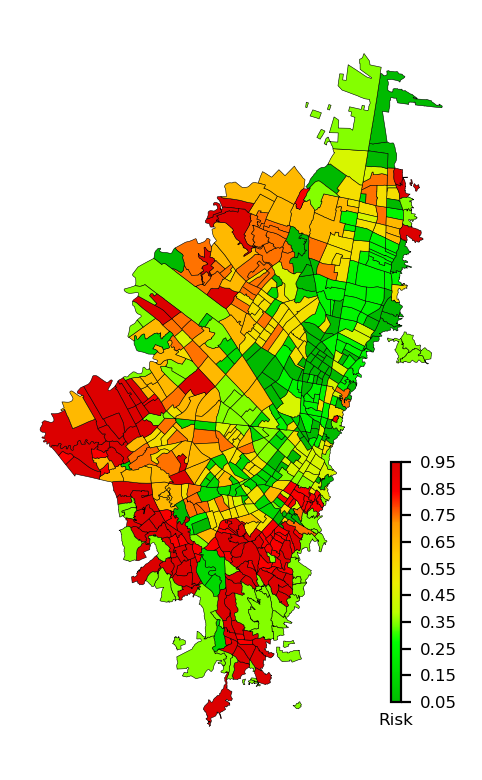

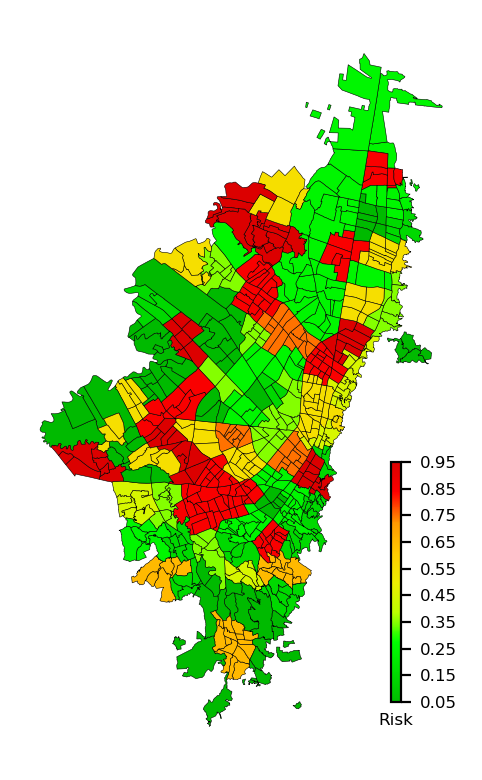

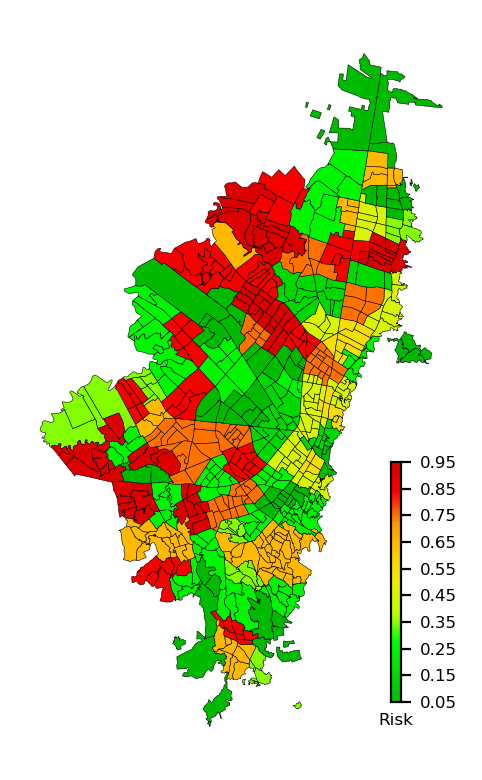

In [11]:

def plotVulnerabilityMap_full(var, cl, truncated = (0.5, 0.9)):
    myDPI = 200
    
    fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)

    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])

    listOfColors = [resultsBorda[cl]['colors'][i]['color'] for i in range(cl)]
    # print(listOfColors)
    cmapVulnerability = matplotlib.colors.ListedColormap(listOfColors) 
    sectorUrbanoWithVariablesNormalizedClusters.plot(ax = ax, column = var, edgecolor='black', cmap = cmapVulnerability, lw=0.2)

    ax.axis('off')
    
    cax = plt.axes([0.625, 0.11, 0.008, 0.3])
    cax.tick_params(axis='both', which='major', labelsize=6)
    cax.tick_params(axis='both', which='minor', labelsize=6)
    #cax.set_xlabel(var.split('-')[-1] + ' risk', fontsize=6)
    cax.set_xlabel('Risk', fontsize=6)

    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])
    some = ScalarMappable(cmap=new_cmap)
        

    some.set_clim(0, 1)
    cbar = fig.colorbar(some, 
                        cax=cax)
    
    # colors_clusters = [new_cmap(float(i)/float(cl-1)) for i in range(cl)]    
    cbar.set_ticks([float(i)/float(cl-1) for i in range(cl)])
    
    if cl == 3:
        cbar.set_ticklabels(['Low', 'Medium', 'High'])
    elif cl == 5:
        cbar.set_ticklabels(['Lowest', 'Low', 'Medium', 'High', 'Highest'])
    else:
        #print([str(_) for _ in np.arange(0.05, 0.96, 0.1)])
        cbar.set_ticklabels(np.round(np.arange(0.05, 1., 0.1), 2))
        
    fig.tight_layout()
    # fig.savefig(var + '_Riks.pdf', format='pdf')

def assign_colors(borda_count, cl):
    truncated = (0.1, 0.5)
    cmap = plt.get_cmap('nipy_spectral_r')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])
    
    probabilities   = np.round(np.arange(0.05, 1., 0.1), 2)[::-1]
    colors_clusters = [new_cmap(float(i)/float(cl-1)) for i in range(cl)]    
    
    print(probabilities)
    
    
    colors_map = {}
    for index, value in enumerate(borda_count):
        # print(value, colors_clusters[index])
        colors_map[value] = {'color': colors_clusters[index], 
                             'probability': probabilities[index]}
    
    return colors_map

life = ['Urban density', 'Age', 'Comorbidities', 'Poverty Index',
        'SocioSpatial segregation']

work = ['Educational', 'Cultural',
        'Sports', 'Food market', 'Formal labor', 
        'Informal labor']

movement = ['Public Transportation Dependency', 
           'Transmission Routes',
           'Geographic Impact'
           ]

from sklearn.cluster import *
from sklearn.mixture import GaussianMixture
cl = 10
kmeanModel_10 = KMeans(n_clusters=cl)

sectorUrbanoWithVariablesNormalizedClusters = sectorUrbanoWithVariablesNormalized.copy()

for nameRisk, risk in zip(['Life', 'Work', 'Movement'],[life, work, movement]):
    life_risk = sectorUrbanoWithVariablesNormalized[['SETU_CCDGO'] + [i + "- Normalized" for i in risk]]
    
    print(life_risk.keys())
    
    kmeanModel_10.fit(life_risk[life_risk.columns[1:]])
    life_risk['Cluster ' + str(cl)] = kmeanModel_10.labels_

    def borda_sort(lists):
        scores = {};
        for l in lists:
            for idx, elem in enumerate(l):
                if not elem in scores:
                    scores[elem] = 0
                scores[elem] += idx

        return sorted(scores.keys(), key=lambda x: scores[x],reverse = False)
    #print(life_risk.head())
    #print(life_risk.groupby('Cluster ' + str(cl)).mean())

    clusters = life_risk[['SETU_CCDGO', 'Cluster ' + str(cl)]].set_index('SETU_CCDGO').to_dict(orient='index')
    sectorUrbanoWithVariablesNormalizedClusters['Cluster ' + str(cl) + "-" + nameRisk] = sectorUrbanoWithVariablesNormalized['SETU_CCDGO'].apply(lambda x: clusters[x]['Cluster ' + str(cl)])

    # cl = Cluster
    tmpData = life_risk.groupby('Cluster ' + str(cl)).mean()[life_risk.keys()[1:-1]].T
    fullRanking = []
    for i in tmpData.values:
        ranking = [0]*len(i)
        fullRanking.append(i.argsort()[::-1])

    resultsBorda = {}

    tmpData[['Ranking ' + str(key) for key in tmpData.keys()]] = fullRanking
    borda_count_vulnerability = borda_sort(tmpData[tmpData.keys()[-cl:]].values)
    resultsBorda[cl] = {'borda_count': borda_count_vulnerability, 
                        'colors': assign_colors(borda_count_vulnerability, cl)}

    
    probabilities = [resultsBorda[cl]['colors'][i]['probability'] for i in range(cl)]
    sectorUrbanoWithVariablesNormalizedClusters['Cluster ' + str(cl) + "-" + nameRisk + '-Probability'] = sectorUrbanoWithVariablesNormalizedClusters['Cluster ' + str(cl) + "-" + nameRisk].apply(lambda x: probabilities[x])
    
    # print(life_risk.head())
    plotVulnerabilityMap_full('Cluster ' + str(cl) + "-" + nameRisk , cl)

## Create the risk-based complex network

In [19]:
variables = sectorUrbanoWithVariablesNormalizedClusters.columns[:10].tolist() + sectorUrbanoWithVariablesNormalizedClusters.columns[-6:].tolist()
sectorUrbanoNeighbors = sectorUrbanoWithVariablesNormalizedClusters[variables]

sectorUrbanoNeighbors["NEIGHBORS"] = None  # add NEIGHBORS column
# https://gis.stackexchange.com/questions/281652/find-all-neighbors-using-geopandas

for index, country in sectorUrbanoNeighbors.iterrows():   
    # get 'not disjoint' countries
    neighbors = sectorUrbanoNeighbors[~sectorUrbanoNeighbors.geometry.disjoint(country.geometry)].SETU_CCDGO.tolist()
    # print(neighbors)
    # remove own name from the list
    neighbors = [ name for name in neighbors if country.SETU_CCDGO != name ]
    # add names of neighbors as NEIGHBORS value
    sectorUrbanoNeighbors.at[index, "NEIGHBORS"] = neighbors

sectorUrbanoNeighbors.head()

DPTO_CCDGO MPIO_CCDGO CPOB_CCDGO          SETU_CCNCT  SHAPE_Leng  \
1538         11      11001   11001000  110011000000001101    0.017602   
1539         11      11001   11001000  110011000000001102    0.024178   
1540         11      11001   11001000  110011000000001103    0.051139   
1541         11      11001   11001000  110011000000001104    0.032833   
1542         11      11001   11001000  110011000000001105    0.072244   

      SHAPE_Area SETU_CCDGO  \
1538    0.000014       1101   
1539    0.000021       1102   
1540    0.000072       1103   
1541    0.000032       1104   
1542    0.000071       1105   

                                               geometry      area  \
1538  POLYGON ((-74.08034 4.58187, -74.08064 4.58165...  0.172533   
1539  POLYGON ((-74.07819 4.58107, -74.07789 4.58081...  0.266636   
1540  POLYGON ((-74.07046 4.57786, -74.07037 4.57765...  0.896132   
1541  POLYGON ((-74.06825 4.56809, -74.06821 4.56800...  0.400737   
1542  POLYGON ((-74.07426 4.56748, -74.07413 4.56735...  0.885145   

                       centroid  Cluster 10-Life  Cluster 10-Life-Probability  \
1538  POINT (-74.08160 4.58323)                9                         0.45   
1539  POINT (-74.08002 4.57926)                7                         0.75   
1540  POINT (-74.07353 4.57410)                2                         0.35   
1541  POINT (-74.06817 4.56410)                2                         0.35   
1542  POINT (-74.07707 4.56209)                2                         0.35   

      Cluster 10-Work  Cluster 10-Work-Probability  Cluster 10-Movement  \
1538                1                         0.25                    2   
1539                1                         0.25                    2   
1540                8                         0.15                    2   
1541                8                         0.15                    6   
1542                8                         0.15                    6   

      Cluster 10-Movement-Probability  \
1538                             0.25   
1539                             0.25   
1540                             0.25   
1541                             0.65   
1542                             0.65   

                                             NEIGHBORS  
1538              [1102, 1110, 1207, 1210, 3202, 3211]  
1539  [1101, 1103, 1109, 1110, 3202, 3210, 3211, 3216]  
1540  [1102, 1104, 1108, 1109, 1115, 3208, 3209, 3216]  
1541                          [1103, 1105, 1108, 1115]  
1542        [1104, 1106, 1107, 1108, 1308, 1312, 1314]

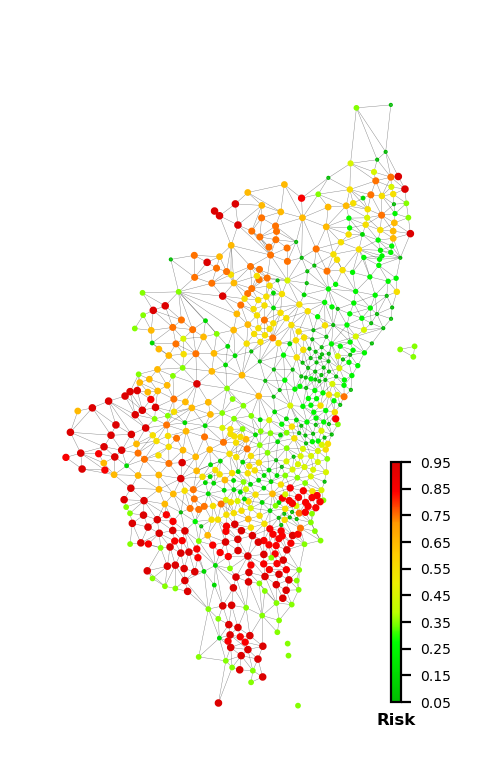

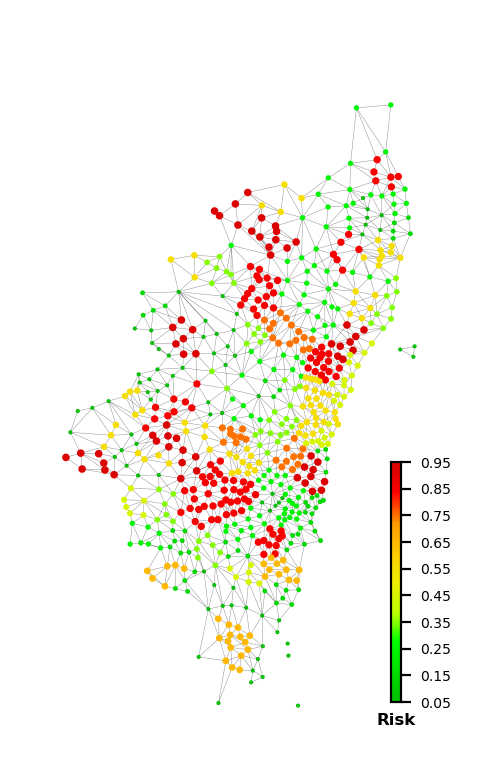

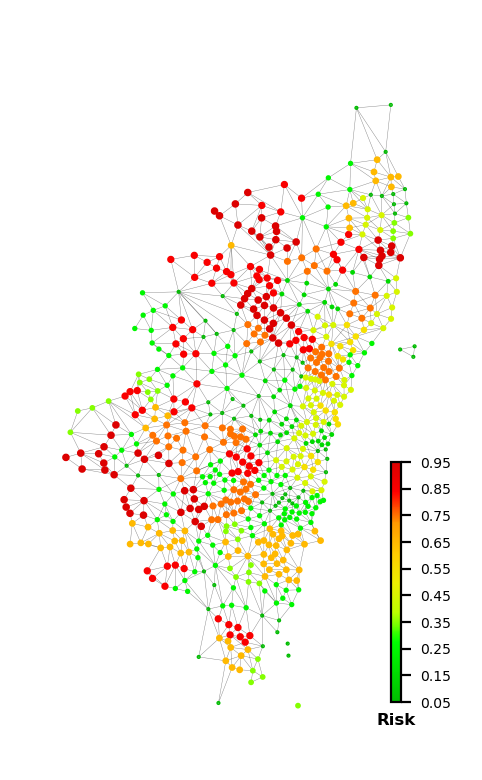

In [20]:
G=nx.Graph()

pos = {}
for node in sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid']].values:
    pos[node[0]] = (node[1].x, node[1].y)


sub_pos = {}
edges = []
alreadyEdges = set()
for node in sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid', 'NEIGHBORS']].values:
    for neighbors in node[-1]:
        if (node[0], neighbors) not in alreadyEdges:
            edges.append((node[0], neighbors))
            alreadyEdges.add((node[0], neighbors))
            alreadyEdges.add((neighbors, node[0]))
        
        
        sub_pos[node[0]] = pos[node[0]]
        sub_pos[neighbors] = pos[neighbors]


G.add_nodes_from(pos.keys())
G.add_edges_from(edges)


for riskName in ['Life', 'Work', 'Movement']:

    myDPI = 200
    fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)
    sectorUrbano.plot(ax = ax, edgecolor='none', facecolor='none', lw=0.2)

    nodeColors = []
    for node in list(G.nodes()):
        value = sectorUrbanoNeighbors[sectorUrbanoNeighbors['SETU_CCDGO']==node]['Cluster 10-' + riskName +'-Probability'].values[0]
        nodeColors.append(value)


    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, 0.5, 0.9)


    cax = plt.axes([0.625, 0.11, 0.008, 0.3])
    cax.tick_params(axis='both', which='major', labelsize=5)
    cax.tick_params(axis='both', which='minor', labelsize=5)
    cax.set_xlabel('Risk', fontsize=6, fontweight='bold')

    some = ScalarMappable(cmap=new_cmap)


    some.set_clim(0, 1)
    cbar = fig.colorbar(some, 
                        cax=cax)

    cbar.set_ticks([float(i)/float(cl-1) for i in range(cl)])
    cbar.set_ticklabels(np.round(np.arange(0.05, 1., 0.1), 2))

    nodes = nx.draw_networkx_nodes(G, pos=pos, ax=ax, 
                                       node_size=np.array(nodeColors)*3+0.1, node_color = nodeColors, 
                                       cmap=new_cmap)

    arcs = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color = 'black', 
                                  arrowstyle='-', 
                                  width=0.15, alpha=0.5,  arrows = True, 
                                  connectionstyle ='arc3,rad=0.01')

    ax.axis('off')
    fig.tight_layout()
    # fig.savefig(riskName + '_network.pdf', format='pdf')

In [23]:
PlaceID = sectorUrbanoNeighbors[['SETU_CCDGO']].T.values

RiskValues = sectorUrbanoNeighbors[['Cluster 10-Life-Probability', 
                                    'Cluster 10-Work-Probability', 
                                    'Cluster 10-Movement-Probability']].T.values

np.savetxt("./Data/PlaceID.csv", PlaceID, delimiter=",", fmt='%s')
np.savetxt("./Data/Risk.csv", np.round(RiskValues, 2), delimiter=",", fmt='%.2f')

G1 = np.zeros((PlaceID.shape[1], PlaceID.shape[1]))
np.savetxt("./Data/G1.csv", G1, delimiter=",", fmt='%.0f')
G2 = 0.5*nx.to_numpy_matrix(G)
np.savetxt("./Data/G2.csv", G2, delimiter=",", fmt='%.2f')
sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid']]

from shapely.geometry import Polygon
import geopy.distance
points_df  = gp.GeoDataFrame(sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid']], geometry='centroid')
points_df = points_df.to_crs('EPSG:3118')

points_df['centroid'].tolist()[0].distance(points_df['centroid'].tolist()[-1])

G3 = nx.to_numpy_matrix(G)
tmpG3 = G3.copy()
nodes = points_df['centroid'].tolist()

minx, miny, maxx, maxy = Polygon([(i.x, i.y) for i in sectorUrbanoNeighbors['centroid']]).bounds
maxDistance = geopy.distance.distance((minx, miny), (maxx, maxy)).m
print(maxDistance/3)

for i in range(G3.shape[0]):
    for j in range(G3.shape[1]):
        if G3[i,j] == 1: 
            G3[i,j] = nodes[i].distance(nodes[j])
            

G3 = (tmpG3 - (G3/G3.max()))/2
np.savetxt("./Data/G3.csv", G3, delimiter=",", fmt='%.3f')

7943.470220959062


## Run in platEMO the files:

- ./Data/RRA1.m
- ./Data/RRA2.m
- ./Data/RRA3.m

And the following to build the result file
- ./Data/BuildResults.m

## Results

In [36]:
from pymoo.factory import get_problem, get_visualization, get_decomposition
from scipy import io
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap


In [37]:
# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, inverse, return_mask = True):
    """conda ac
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index < len(costs):
        if inverse: 
            nondominated_point_mask = np.any(costs > costs[next_point_index], axis=1)
        else:
            nondominated_point_mask = np.any(costs < costs[next_point_index], axis=1)
            
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [38]:
def readBestSolutions(percentage, problem):
    C = io.loadmat('./Results/FullResults_' + percentage + '_' + problem + '.mat')
    C = C['C']

    #X = np.asarray(results_RRA1['fullObjFinal'])[:, :, 0]

    #for i in range(1, 20):
        #X = np.concatenate((X, np.asarray(results_RRA1['fullObjFinal'])[:,:, i]))

    X = C[0][1]
    for i in range(1, 20):
        X = np.concatenate((X, C[i][1]))
        
        
    Y = C[0][0]
    for i in range(1, 20):
        Y = np.concatenate((Y, C[i][0]))


    #X = np.asarray(results_RRA1['fullObj'])
    paretoFront = is_pareto_efficient(X, inverse = False)
    Xmin = X[paretoFront, :]

    paretoFront = is_pareto_efficient(X, inverse = True)
    Xmax = X[paretoFront, :]
    # print(len(Xmin))
    
    return X, Y, Xmin, Xmax
    
#weights = np.array([0.333, 0.3333, 0.33333])
#decomp = get_decomposition("asf")
#I = get_decomposition("asf").do(Xmin, weights).argmin()
#print("Best regarding decomposition: Point %s - %s" % (I, Xmin[I]))

def plotSubfig(ax, Xmin, Xmax, angle, ticks=None):
    ax.tick_params(direction='out', length=1, width=10, grid_alpha=0.5)
    
    ax.xaxis.pane.set_facecolor('w')
    ax.yaxis.pane.set_facecolor('w')
    ax.zaxis.pane.set_facecolor('w')

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.w_xaxis._axinfo.update({'grid': {'color': (0, 0, 0, 0.1),
                                        'linewidth':0.4,
                                        'linestyle':'--'}})

    ax.w_yaxis._axinfo.update({'grid': {'color': (0, 0, 0, 0.1),
                                        'linewidth': 0.4,
                                        'linestyle': '--'}})

    ax.w_zaxis._axinfo.update({'grid': {'color': (0, 0, 0, 0.1),
                                        'linewidth': 0.4,
                                        'linestyle': '--'}})
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_locator(MaxNLocator(integer=True))    


    best = ax.scatter(Xmin[:, 1], 
                      Xmin[:, 0], 
                      Xmin[:, 2],
                      label='Best solutions', s=15, color='C3')
    '''
    worst = ax.scatter(Xmax[:, 1], 
                       Xmax[:, 0], 
                       Xmax[:, 2],
                       label='Worst solutions', s=10, color='r')
    '''
    
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)

    ax.set_xlabel(r'$\it{\mathbf{Life}}$', rotation=0, fontsize=12)
    ax.set_ylabel(r'$\bf{Work}$', rotation=0, fontsize=12)
    ax.set_zlabel(r'$\bf{Movement}$', rotation=0, fontsize=12)
    
    if ticks == None:
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 5)
        ax.set_xticks(np.around(x, 1))

        x = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)
        ax.set_yticks(np.around(x, 1))
        
        x = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], 5)
        ax.set_zticks(np.around(x, 1))
    # print()
    else:
        xTicks, yTicks, zTicks = ticks
        ax.set_xticks(xTicks)
        ax.set_yticks(yTicks)
        ax.set_zticks(zTicks)
        
    

    if angle == 315:
    #if angle == 45:
        tmp_planes = ax.zaxis._PLANES
        ax.zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                            tmp_planes[0], tmp_planes[1],
                            tmp_planes[4], tmp_planes[5])

        ax.plot_trisurf(Xmin[:, 1], 
                        Xmin[:, 0], 
                        Xmin[:, 2], color='C0', alpha=0.2,linewidths=0.2, antialiased = True, )
        
        ax.view_init(20, angle)
        

    else:
        ax.plot_trisurf(Xmin[:, 1], 
                        Xmin[:, 0], 
                        #Xmin[:, 2], cmap='RdYlGn_r', alpha=0.2,linewidths=0.2, antialiased = True, )
                        Xmin[:, 2], color='C0', alpha=0.2,linewidths=0.2, antialiased = True, )
        ax.view_init(20, angle)

    #return ax, best, worst
    return ax, best, None, [ax.get_xticks(), ax.get_yticks(), ax.get_zticks()]

def plotParetoFront(Xmin, Xmax, percentage, problem):
    fig = plt.figure(figsize=(8, 8))
    #ax = fig.add_subplot(111, projection='3d')
    left, bottom, width, height = [0.1, 0.1, 0.65, 0.65]
    ax = fig.add_axes([left, bottom, width, height],  projection='3d')
    ax, best, _, ticksAlready = plotSubfig(ax, Xmin, Xmax, angle=315, ticks=None)

    ax.legend(handles=[Patch(color='C0', alpha=0.3,
                             label='Approx. Pareto Front'),
                       best], 
              loc=4,  bbox_to_anchor=(1.15, 0.3, 0.05, 0.05), fontsize=12)
    print(ticksAlready)
    left, bottom, width, height = [0.555, 0.505, 0.45, 0.45]
    ax2 = fig.add_axes([left, bottom, width, height],  projection='3d')
    plotSubfig(ax2, Xmin, Xmax, angle=45, ticks=ticksAlready)
    #plotSubfig(ax2, Xmax, angle=45, colorScatter='b')
    
    #fig.tight_layout()
    # plt.savefig('./Test/' + percentage + '_' + problem + '_plotPareto.pdf', format='pdf')
    

10p RRA1
[array([274.6, 276.3, 277.9, 279.5, 281.1]), array([296.1, 297.5, 299. , 300.4, 301.8]), array([269.3, 270.4, 271.5, 272.6, 273.7])]
10p RRA2
[array([2036.8, 2039.7, 2042.6, 2045.5, 2048.4]), array([2138.4, 2141.7, 2145. , 2148.2, 2151.5]), array([1966.2, 1967.2, 1968.3, 1969.3, 1970.4])]
10p RRA3
[array([2053.6, 2058.6, 2063.7, 2068.7, 2073.8]), array([2155.8, 2158.1, 2160.5, 2162.8, 2165.2]), array([1982.9, 1986.4, 1989.9, 1993.3, 1996.8])]
25p RRA1
[array([247.3, 250.5, 253.8, 257.1, 260.4]), array([268.4, 270.8, 273.2, 275.5, 277.9]), array([242.2, 244.5, 246.9, 249.3, 251.7])]
25p RRA2
[array([1936.3, 1939.4, 1942.6, 1945.7, 1948.8]), array([2024.1, 2030.1, 2036.2, 2042.3, 2048.4]), array([1865.8, 1868. , 1870.2, 1872.4, 1874.6])]
25p RRA3
[array([1961.5, 1968. , 1974.6, 1981.2, 1987.7]), array([2068.9, 2072.3, 2075.7, 2079.1, 2082.5]), array([1894.7, 1899.2, 1903.6, 1908.1, 1912.5])]
50p RRA1
[array([208.4, 209.8, 211.3, 212.7, 214.2]), array([226.2, 229.2, 232.3, 235.4,

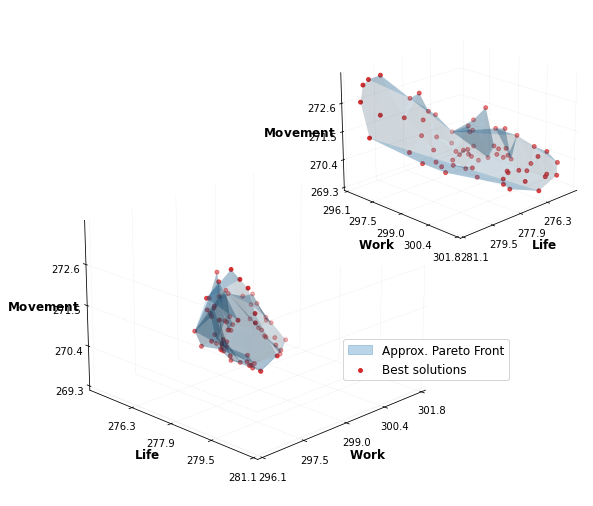

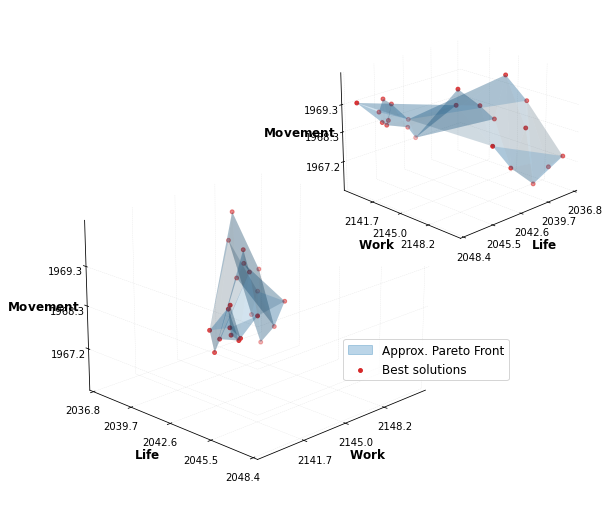

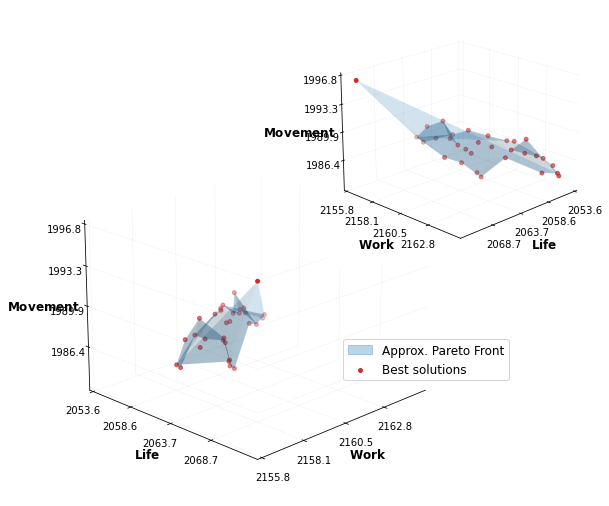

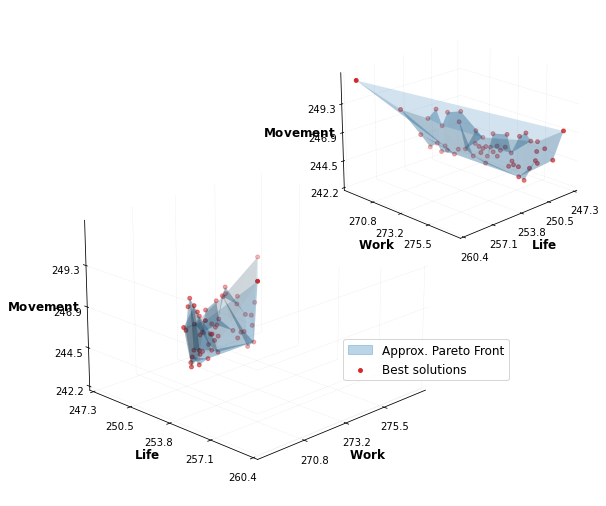

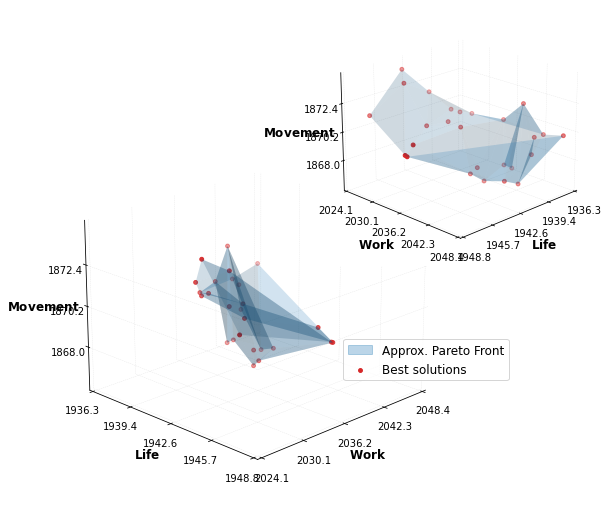

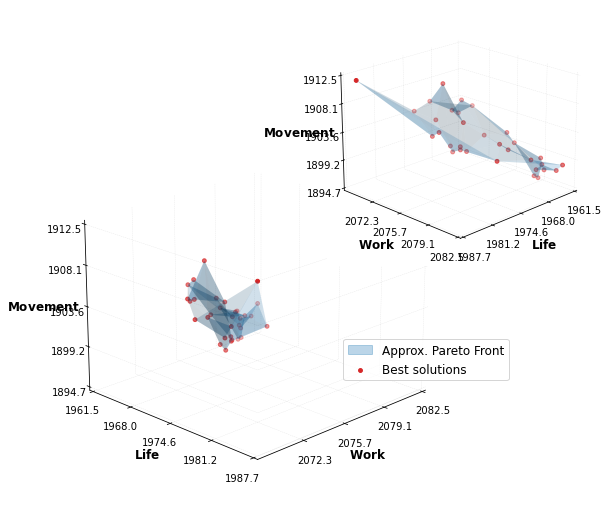

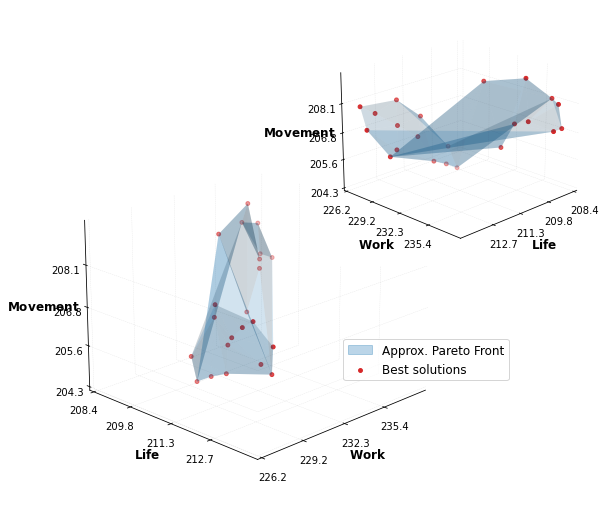

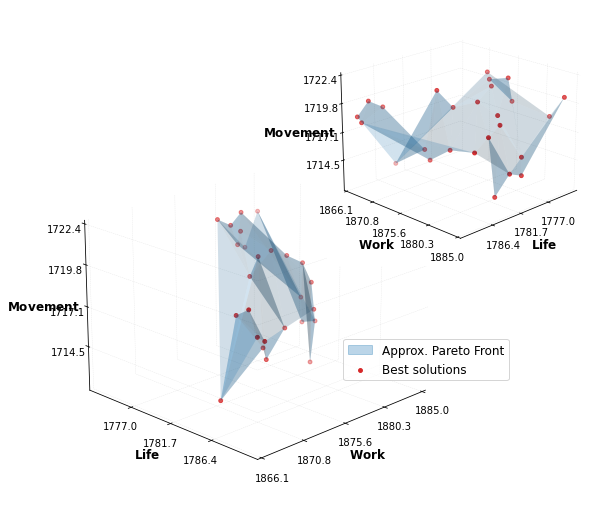

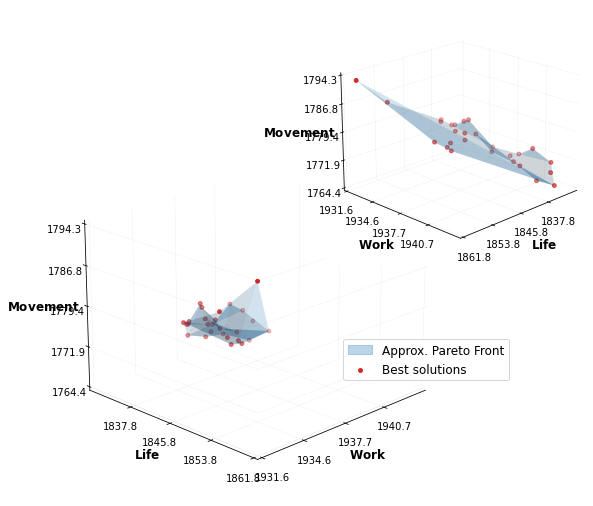

In [39]:
percentages = ['10p', '25p', '50p'];
problems    = ['RRA1', 'RRA2', 'RRA3'];

#for per in percentages[-1:]:
    #for pr in problems[1:2]:
for per in percentages:
    for pr in problems:
        print(per, pr)
        X, Y, Xmin, Xmax = readBestSolutions(per, pr)
        plotParetoFront(Xmin, Xmax, per, pr)

In [40]:
G=nx.Graph()

pos = {}
for node in sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid']].values:
    pos[node[0]] = (node[1].x, node[1].y)

labels = pd.read_csv("./Data/PlaceID.csv", header=None).values.astype('str')[0]
G3     = pd.read_csv("./Data/G3.csv", header=None)
G3.columns = labels
G3.index   = labels

sub_pos = {}
edges = []
alreadyEdges = set()
for node in sectorUrbanoNeighbors[['SETU_CCDGO', 'centroid', 'NEIGHBORS']].values:
    for neighbors in node[-1]:
        if (node[0], neighbors) not in alreadyEdges:
            edges.append((node[0], neighbors, {'weight': G3.at[node[0], neighbors]}))
            alreadyEdges.add((node[0], neighbors))
            alreadyEdges.add((neighbors, node[0]))

        
        sub_pos[node[0]] = pos[node[0]]
        sub_pos[neighbors] = pos[neighbors]


G.add_nodes_from(pos.keys())
G.add_edges_from(edges)


edgesFull, weightsFull = zip(*nx.get_edge_attributes(G,'weight').items())

def plotSolutionsMap(problem, MORRA_results, extraName=None):
    cmapReal = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmapReal, 0.5, 0.9)
    
    #new_cmap=plt.get_cmap('RdBu')
        
    my_cmap = new_cmap(np.arange(new_cmap.N))
    my_cmap[:,-1] = np.array([0.6 for _ in range(new_cmap.N)])
    # print(my_cmap)
    my_cmap = ListedColormap(my_cmap)
    
#for riskName in ['Life']:
    for riskName in ['Life', 'Work', 'Movement']:
        myDPI = 200
        fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)
        # sectorUrbano.plot(ax = ax, edgecolor='none', facecolor='none', lw=0.2)
        MORRA_results.plot(ax = ax, column = 'Cluster 10-' + riskName + '-Probability', 
                           edgecolor='black', cmap=my_cmap,  lw=0.2)
        

        nodeColors     = new_cmap(MORRA_results['Cluster 10-' + riskName +'-Probability'])
        nodeSize       = MORRA_results['Cluster 10-' + riskName +'-Probability']
        nodeSize       = np.array(nodeSize)*3 + 0.5
        nodeColorEdges = nodeColors.copy()
        
        MORRA_results[MORRA_results['Result']==1].plot(ax = ax, edgecolor='darkblue', facecolor='none', lw=0.75)
        
        for index, node in enumerate(list(G.nodes())):
            isSolution = MORRA_results[MORRA_results['SETU_CCDGO']==node]['Result'].values[0]
            if isSolution == 1:
                nodeColorEdges[index] = [0, 0, 1, 1]
            else:
                nodeColorEdges[index] = nodeColors[index][:3].tolist() + [0.65]
                nodeColors[index] = nodeColors[index][:3].tolist() + [0.65]
                

        
        cax = plt.axes([0.655, 0.11, 0.008, 0.3])
        cax.tick_params(axis='both', which='major', labelsize=6)
        cax.tick_params(axis='both', which='minor', labelsize=6)
        cax.set_xlabel('Risk', fontsize=6)
        
        some = ScalarMappable(cmap=my_cmap)


        some.set_clim(0, 1)
        cbar = fig.colorbar(some,
                            cax=cax)

        cbar.set_ticks([float(i)/float(cl-1) for i in range(cl)])
        cbar.set_ticklabels(np.round(np.arange(0.05, 1., 0.1), 2))

        '''
        if problem == 'RRA1':
            pass
        elif problem == 'RRA2':
            arcs = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color = 'grey', 
                                          arrowstyle='-', 
                                          width=0.15, alpha=0.5,  arrows = True, 
                                          connectionstyle ='arc3,rad=0.01')
        else:
            arcs = nx.draw_networkx_edges(G, pos = pos, 
                                          ax  = ax, 
                                          edgelist = edgesFull,
                                          edge_color = weightsFull,
                                          width = weightsFull, alpha=0.5,
                                          edge_cmap = plt.cm.Greys, 
                                         )

        nodes = nx.draw_networkx_nodes(G, pos=pos, ax=ax, 
                                       # node_size  = nodeSize, 
                                       node_size = 4,
                                       node_color = nodeColors, 
                                       # alpha = 0.5,
                                       edgecolors = nodeColorEdges, linewidths = 0.75)
        '''
            
        #legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='b', label='Solution', ls="", markerfacecolor='white', markersize=5),]
        legend_elements = [ Patch(facecolor='white', edgecolor='darkblue', label='Solution')]

        ax.legend(handles=legend_elements, loc=2, bbox_to_anchor=(0.05, 0.85, 0.05, 0.05), fontsize=6)
            
        ax.axis('off')
        fig.tight_layout()

## With equal pseudo-weights (1/3, 1/3, 1/3)

Best regarding decomposition: Point 449 - [298.925 276.225 270.075]
Best regarding decomposition: Point 394 - [2140.65  2043.475 1967.725]
Best regarding decomposition: Point 632 - [2163.978725 2054.481025 1985.340775]


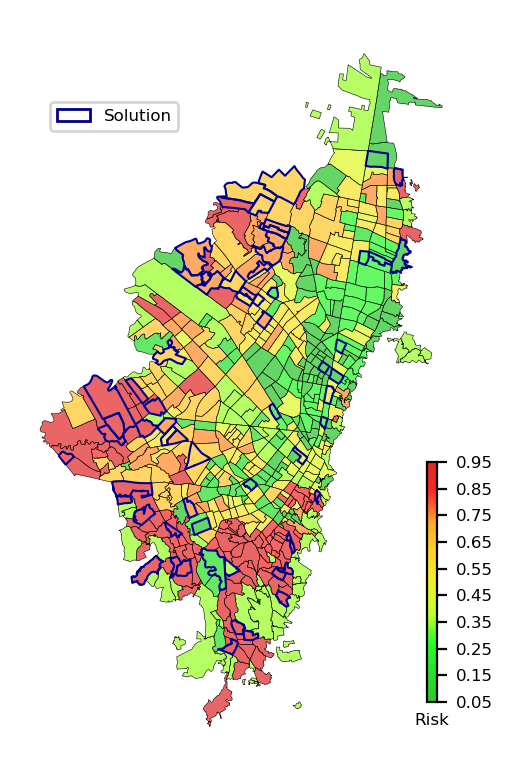

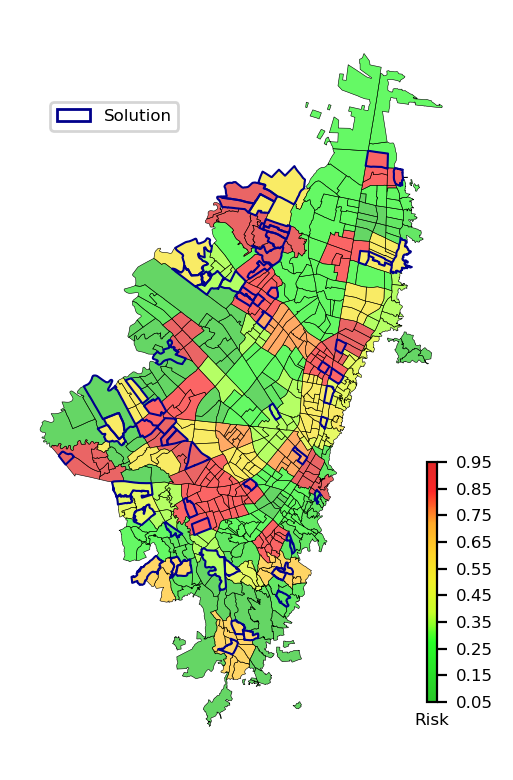

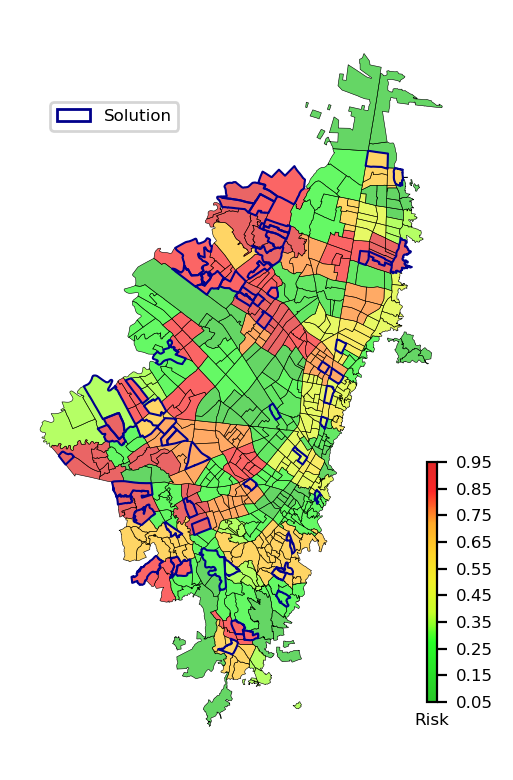

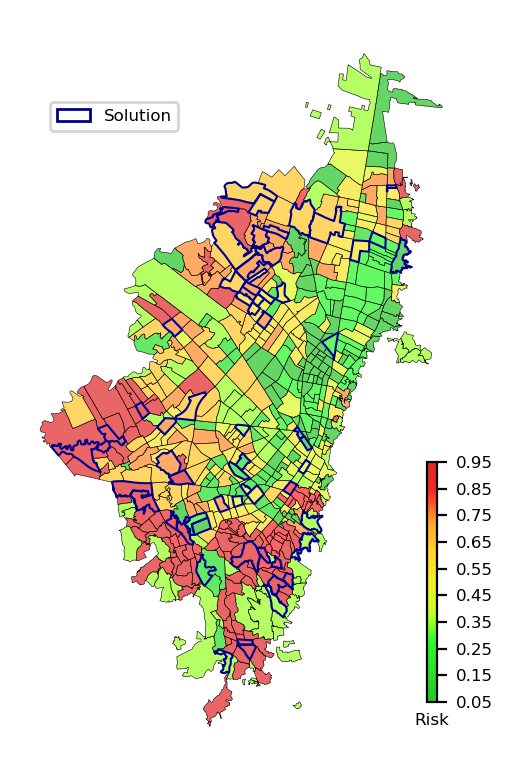

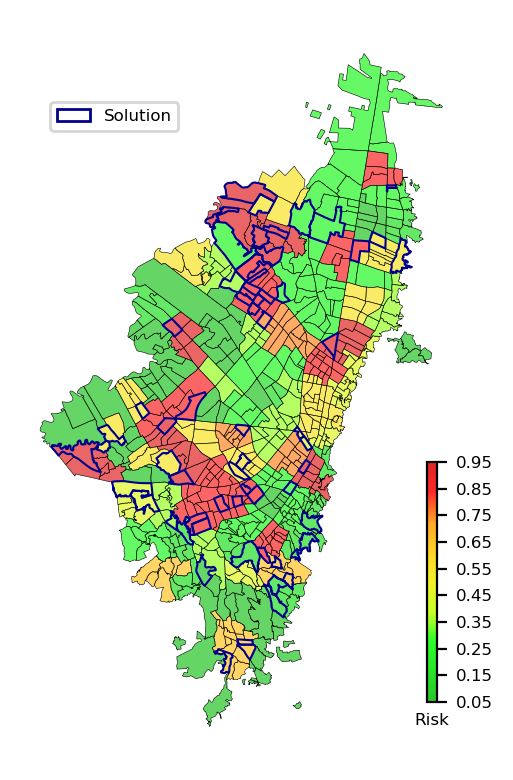

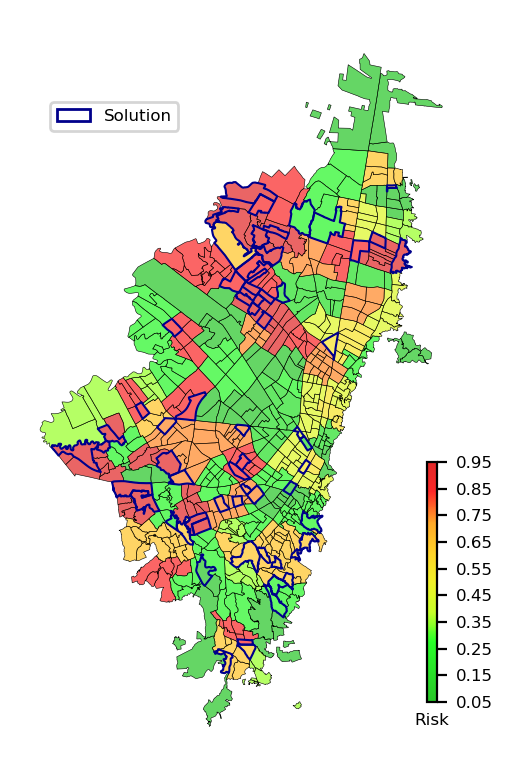

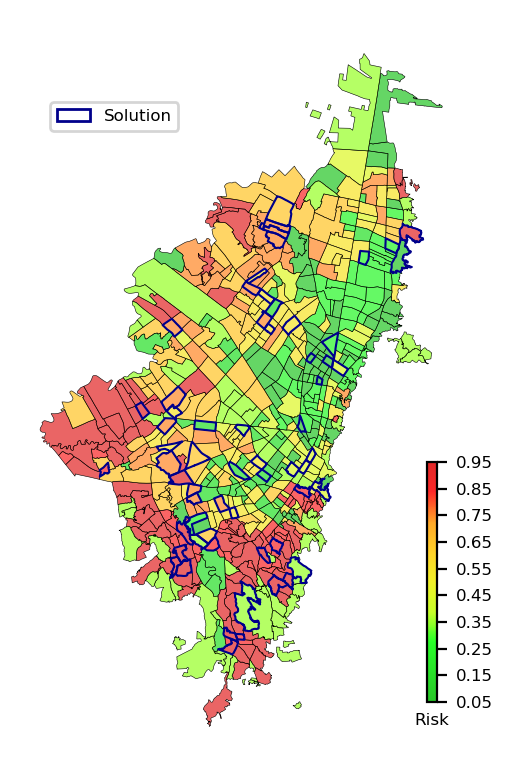

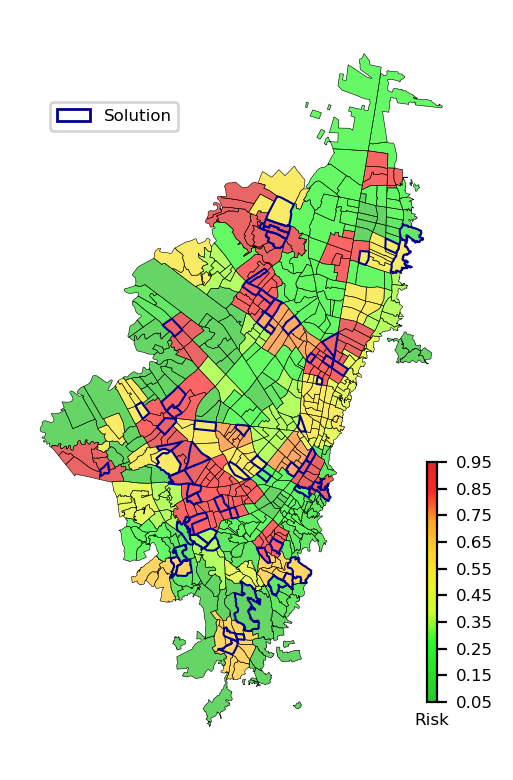

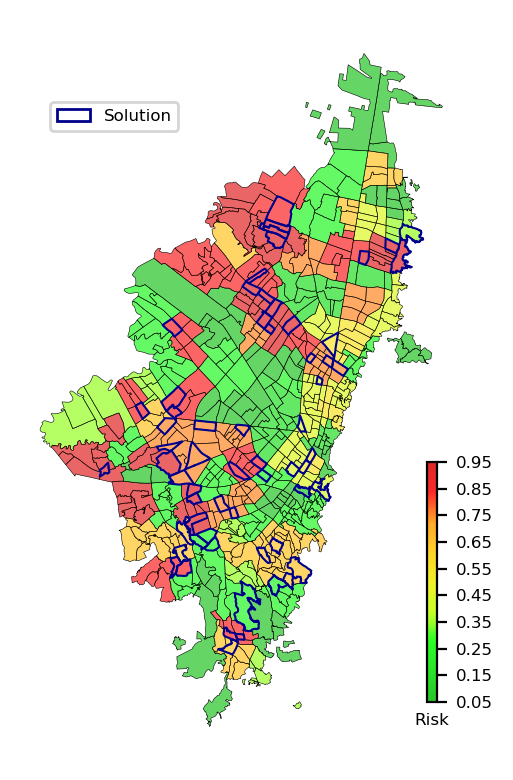

In [41]:
percentages = ['10p', '25p', '50p']
problems    = ['RRA1', 'RRA2', 'RRA3']

#vfor pr in problems[-1:]:
for pr in problems:
    X, Y, Xmin, Xmax = readBestSolutions('10p', pr)

    weights = np.array([0.33333, 0.33333, 0.33333])
    decomp = get_decomposition("weighted-sum")
    I = get_decomposition("weighted-sum").do(X, weights).argmin()
    print("Best regarding decomposition: Point %s - %s" % (I, X[I]))
    
    dec = (Y[I,:] < 63).astype(int)

    MORRA_results = sectorUrbanoNeighbors.copy()
    MORRA_results['Result'] = dec
    
    plotSolutionsMap(pr, MORRA_results, None)

## With different pseudo-weights

31
Best regarding decomposition: Point 460 - [2156.298925 2062.862725 1986.955325]
31
Best regarding decomposition: Point 632 - [2163.978725 2054.481025 1985.340775]
31
Best regarding decomposition: Point 486 - [2160.65575 2060.3122  1983.56255]


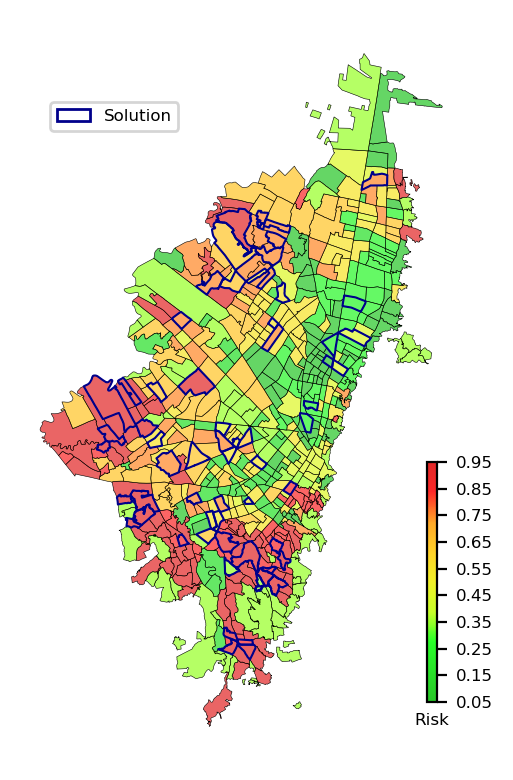

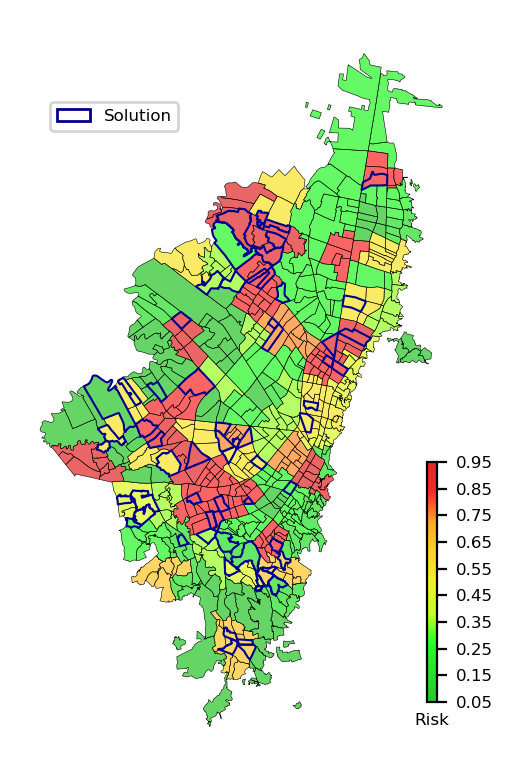

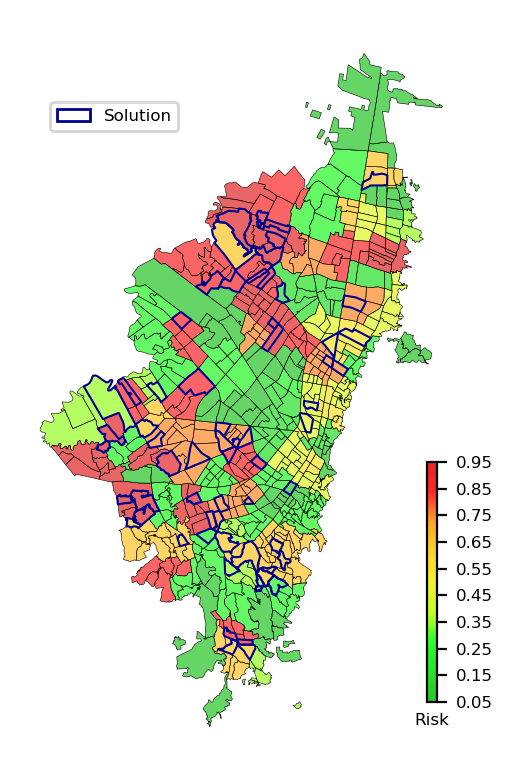

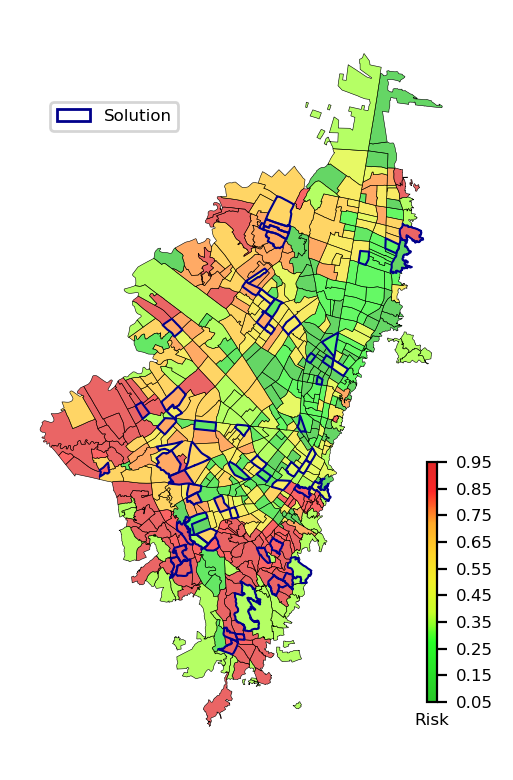

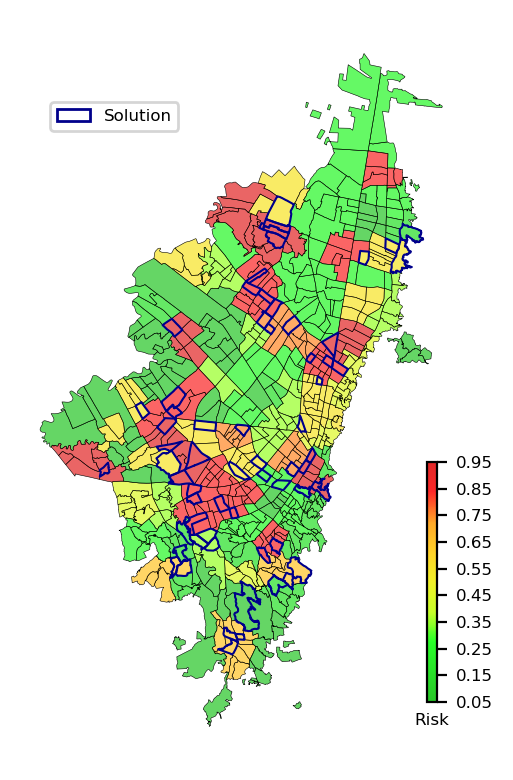

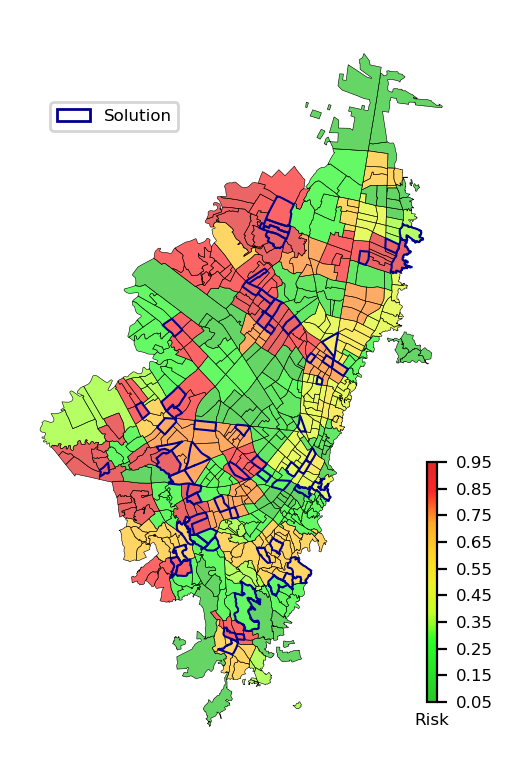

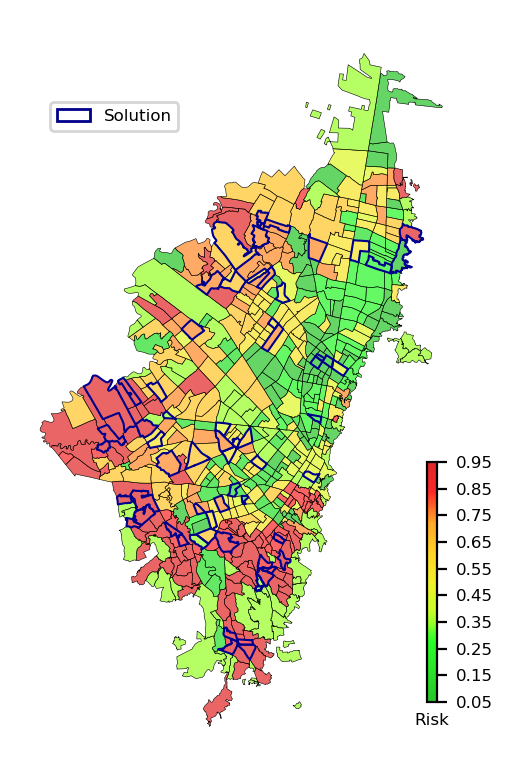

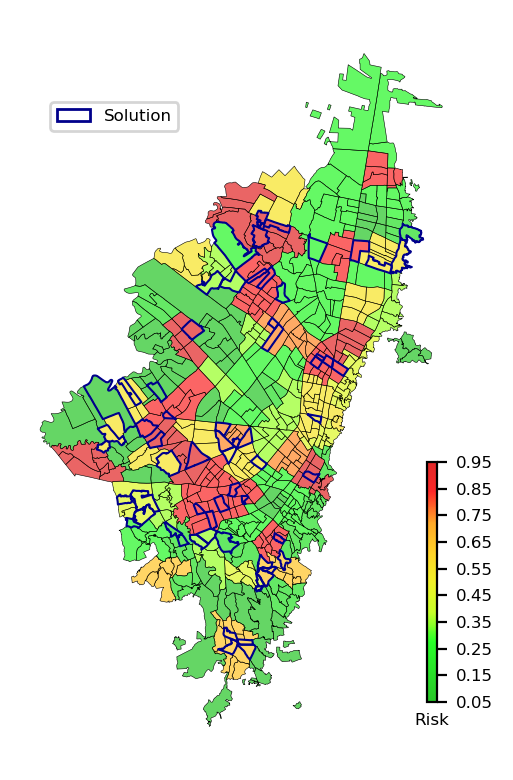

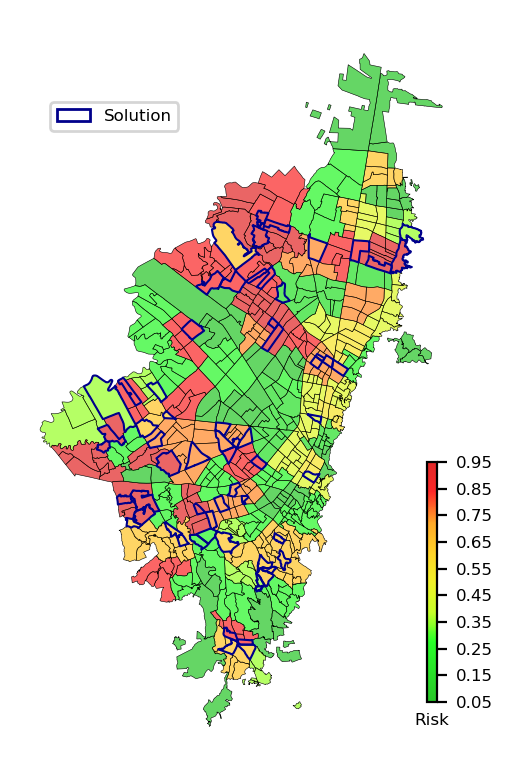

In [43]:
for weights, weightsID in zip([np.array([0.8, 0.1, 0.1]), 
                               np.array([0.1, 0.8, 0.1]), 
                               np.array([0.1, 0.1, 0.8])], 
                              ['moreLife', 'moreWork', 'moreMovement']):
    
    X, Y, Xmin, Xmax = readBestSolutions('10p', 'RRA3')
    decomp = get_decomposition('weighted-sum')
    print(len(Xmin))
    I = get_decomposition('weighted-sum').do(X, weights).argmin()
    print("Best regarding decomposition: Point %s - %s" % (I, X[I]))
    
    dec = (Y[I,:] <= 63).astype(int)

    MORRA_results = sectorUrbanoNeighbors.copy()
    MORRA_results['Result'] = dec
    
    plotSolutionsMap('RRA3', MORRA_results, extraName = weightsID)